## Denosing Autoencoder
```
Denosing autoencoder is a type of autoencoder that is trained to reconstruct the original input from a corrupted version of it by first corrupting the input and then learn to recover the original input.
```

In [2]:
# necessary imports
# add ../src to sys.path
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

import AE as ae

In [3]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor()])

# datasets
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


# data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

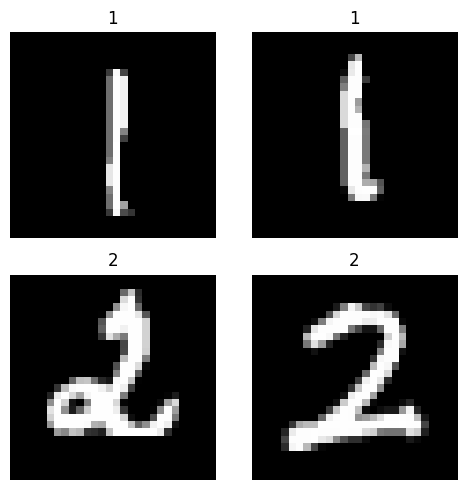

In [4]:
# visualize some data
def visualize_data(data, labels):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs = axs.flatten()
    for i in range(4):
        axs[i].imshow(data[i].squeeze(), cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# visualize some data
imgs, labels = next(iter(trainloader))
visualize_data(imgs, labels)

In [5]:
# corrupt the data with gaussian noise
def gaussian_noise(data, mean=0, std=0.1):
    noise = torch.randn(data.size()) * std + mean
    return data + noise

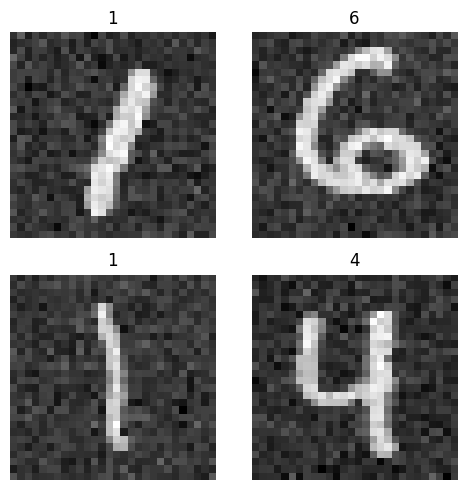

In [6]:
# visualize some data
imgs, labels = next(iter(trainloader))
imgs = gaussian_noise(imgs)
visualize_data(imgs, labels)

In [7]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# image size
img_size = imgs[0].shape[1]**2 # 28*28 = 784
# latent size
latent_size = 20

In [39]:
# define model
model = ae.AE(img_size, latent_size).to(device)

# pass some data through the model
imgs, labels = next(iter(trainloader)) #imgs.shape = [batch_size, 1, 28, 28], labels.shape = [128]

# flatten images
imgs = imgs.view(imgs.shape[0], -1).to(device) #imgs.shape = [128, 784]
recon_imgs, encoded_imgs = model(imgs)

print('Reconstructed images shape: ', recon_imgs.shape)
print('Encoded images shape: ', encoded_imgs.shape)

Reconstructed images shape:  torch.Size([128, 784])
Encoded images shape:  torch.Size([128, 20])


In [40]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# loss function
criterion = nn.MSELoss()

In [41]:
# training loop
epochs = 100

for epoch in trange(epochs):
    for i, (imgs, labels) in enumerate(trainloader):

        # flatten images
        imgs = imgs.view(imgs.shape[0], -1).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        recon_imgs, encoded_imgs = model(imgs.to(device))

        # compute loss
        loss = criterion(recon_imgs, imgs)

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

    # print loss
    if epoch % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))

  1%|          | 1/100 [00:03<06:08,  3.72s/it]

Epoch: 0, Loss: 0.0218


 11%|█         | 11/100 [00:39<05:17,  3.56s/it]

Epoch: 10, Loss: 0.0066


 21%|██        | 21/100 [01:15<04:43,  3.59s/it]

Epoch: 20, Loss: 0.0064


 31%|███       | 31/100 [01:51<04:07,  3.59s/it]

Epoch: 30, Loss: 0.0061


 41%|████      | 41/100 [02:28<03:37,  3.69s/it]

Epoch: 40, Loss: 0.0061


 51%|█████     | 51/100 [03:05<03:01,  3.70s/it]

Epoch: 50, Loss: 0.0056


 61%|██████    | 61/100 [03:41<02:26,  3.75s/it]

Epoch: 60, Loss: 0.0054


 71%|███████   | 71/100 [04:19<01:51,  3.86s/it]

Epoch: 70, Loss: 0.0052


 81%|████████  | 81/100 [04:56<01:08,  3.60s/it]

Epoch: 80, Loss: 0.0050


 91%|█████████ | 91/100 [05:32<00:32,  3.60s/it]

Epoch: 90, Loss: 0.0047


100%|██████████| 100/100 [06:05<00:00,  3.65s/it]


In [42]:
# test model
imgs, labels = next(iter(testloader))
imgs = imgs.view(imgs.shape[0], -1).to(device)
recon_imgs, encoded_imgs = model(imgs.to(device))

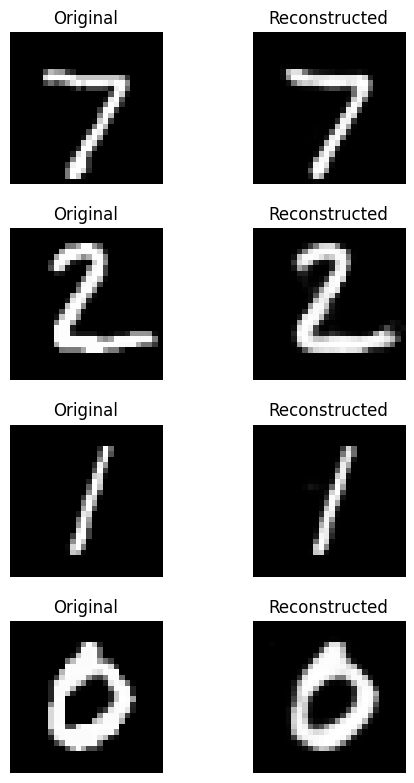

In [61]:
# visualize the original and reconstructed images. 2x2 grid
# first column: original images, second column: reconstructed images
plt.subplots(4,2, figsize=(5,8))
plt.tight_layout()
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(imgs[i].detach().cpu().view(28,28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(4,2,2*i+2)
    plt.imshow(recon_imgs[i].detach().cpu().view(28,28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

```
Seems like the model worked quite well! Good job! 
```